In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Subset
torch.set_num_threads(1)




# Modèle CVAE
class CVAE(nn.Module):
    def __init__(self, latent_dim=10, num_classes=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encodeur
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28 + num_classes, 400),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)


        # Décodeur
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 400),
            nn.ReLU(),
            nn.Linear(400, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x, c):
        x = torch.cat([x, c], dim=1)
        h = self.encoder(x)
        mu = self.fc_mu(h)

        logvar = self.fc_logvar(h)


        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z = torch.cat([z, c], dim=1)
        return self.decoder(z)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

# Fonction de perte
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Chargement des données MNIST
subset_size = 50000
transform = transforms.ToTensor()
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
indices = torch.randperm(len(mnist_data))[:subset_size]
subset_data = Subset(mnist_data, indices)
data_loader = DataLoader(subset_data, batch_size=128, shuffle=True)

# Initialisation du modèle et de l'optimiseur
latent_dim = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cvae = CVAE(latent_dim).to(device)
optimizer = optim.Adam(cvae.parameters(), lr=1e-3,betas=(0.5, 0.999))
cvae.train()
# Entraînement
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(data_loader):
        data = data.to(device).view(-1, 28 * 28)
        labels_one_hot = torch.nn.functional.one_hot(labels, 10).float().to(device)  # Encodage one-hot des labels

        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae(data, labels_one_hot)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss / len(data_loader.dataset):.4f}')




Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 566kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 5.09MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.32MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/100], Loss: 182.1243
Epoch [2/100], Loss: 150.9925
Epoch [3/100], Loss: 145.8559
Epoch [4/100], Loss: 143.4348
Epoch [5/100], Loss: 141.7714
Epoch [6/100], Loss: 140.3599
Epoch [7/100], Loss: 139.2811
Epoch [8/100], Loss: 138.3368
Epoch [9/100], Loss: 137.6083
Epoch [10/100], Loss: 136.9087
Epoch [11/100], Loss: 136.3540
Epoch [12/100], Loss: 135.8851
Epoch [13/100], Loss: 135.4346
Epoch [14/100], Loss: 135.0427
Epoch [15/100], Loss: 134.6904
Epoch [16/100], Loss: 134.3985
Epoch [17/100], Loss: 134.1078
Epoch [18/100], Loss: 133.8327
Epoch [19/100], Loss: 133.5843
Epoch [20/100], Loss: 133.3588
Epoch [21/100], Loss: 133.1241
Epoch [22/100], Loss: 132.9658
Epoch [23/100], Loss: 132.8031
Epoch [24/100], Loss: 132.6225
Epoch [25/100], Loss: 132.4396
Epoch [26/100], Loss: 132.2911
Epoch [27/100], Loss: 132.1486
Epoch [28/100], Loss: 132.0192
Epoch [29/100], Loss: 131.8887
Epoch [30/100], Loss: 131.7868
Epoc

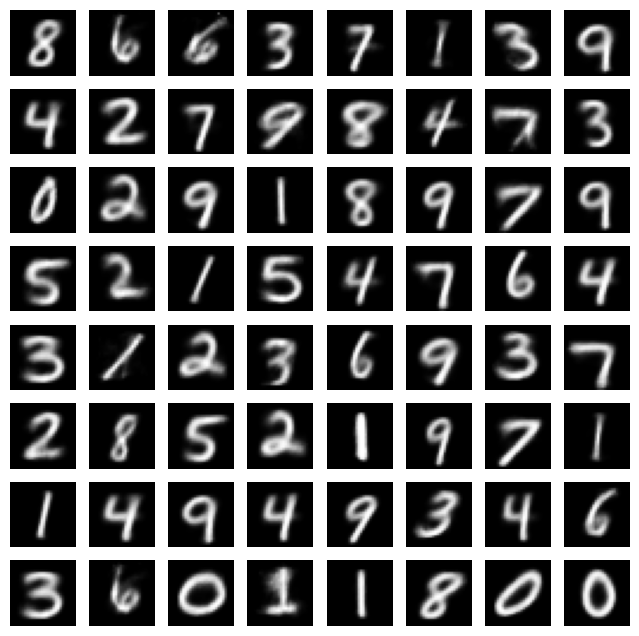

In [2]:

cvae.eval()
with torch.no_grad():
    # Vecteur latent aléatoire
    z = torch.randn(64, latent_dim).to(device)

    # Condition : Générer un "5"
    condition = torch.zeros(64, 10).to(device)

    #pour la géneration d'une classe en particulier
    #condition[:, 0] = 1  # Encode le chiffre 0  en one-hot

    #pour la generation de toute les classe
    for i in range(condition.shape[0]):  # Iterate over each row (vector)
      condition[i, torch.randint(0, 10, (1,))] = 1 # Assign a random digit for each row


    generated_images = cvae.decode(z, condition).cpu().view(-1, 1, 28, 28)

    # Affichage des images générées
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(generated_images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

In [ ]:
import os

# ... (votre code existant) ...

# Génération conditionnelle de "0"
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    condition = torch.zeros(64, 10).to(device)
    condition[:, 0] = 1  # Encode le chiffre 0 en one-hot
    generated_images_0 = cvae.decode(z, condition).cpu().view(-1, 1, 28, 28)

# Génération conditionnelle de "1"
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    condition = torch.zeros(64, 10).to(device)
    condition[:, 1] = 1  # Encode le chiffre 1 en one-hot
    generated_images_1 = cvae.decode(z, condition).cpu().view(-1, 1, 28, 28)

# Sélectionner 3 images de chaque ensemble
selected_images_0 = generated_images_0[:3]
selected_images_1 = generated_images_1[:3]
import torchvision

# Créer un dossier pour les images
os.makedirs('generated_images', exist_ok=True)

# Sauvegarder les images de "0"
for i, img in enumerate(selected_images_0):
    torchvision.utils.save_image(img, os.path.join('generated_images', f'image_0_{i}.png'))

# Sauvegarder les images de "1"
for i, img in enumerate(selected_images_1):
    torchvision.utils.save_image(img, os.path.join('generated_images', f'image_1_{i}.png'))